In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
sns.set_style('darkgrid')

In [56]:
train = pd.read_csv('final_train.csv')
test = pd.read_csv('final_test.csv')

In [58]:
#Dropping the unnecessary columns
train = train.drop(['oem','variant', 'model', 'Height', 'Wheel Base'], axis = 1)#height is incorrectly labelled or recorded
test = test.drop(['oem', 'variant', 'model', 'Height', 'Wheel Base'], axis = 1)

In [59]:
#Creating X_train and y_train
X_train = train.drop('listed_price', axis = 1)
y_train = train['listed_price']
X_test = test.drop('listed_price', axis = 1)
y_test = test['listed_price']
y_test

0        950000.0
1        500000.0
2        738000.0
3        660000.0
4        899999.0
          ...    
3770     295000.0
3771     735859.0
3772     245000.0
3773    1249999.0
3774     200000.0
Name: listed_price, Length: 3775, dtype: float64

In [60]:
corr_mat = train.corr()

/tmp/ipykernel_4854/1976906968.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = train.corr()


## Pearson's Correlation

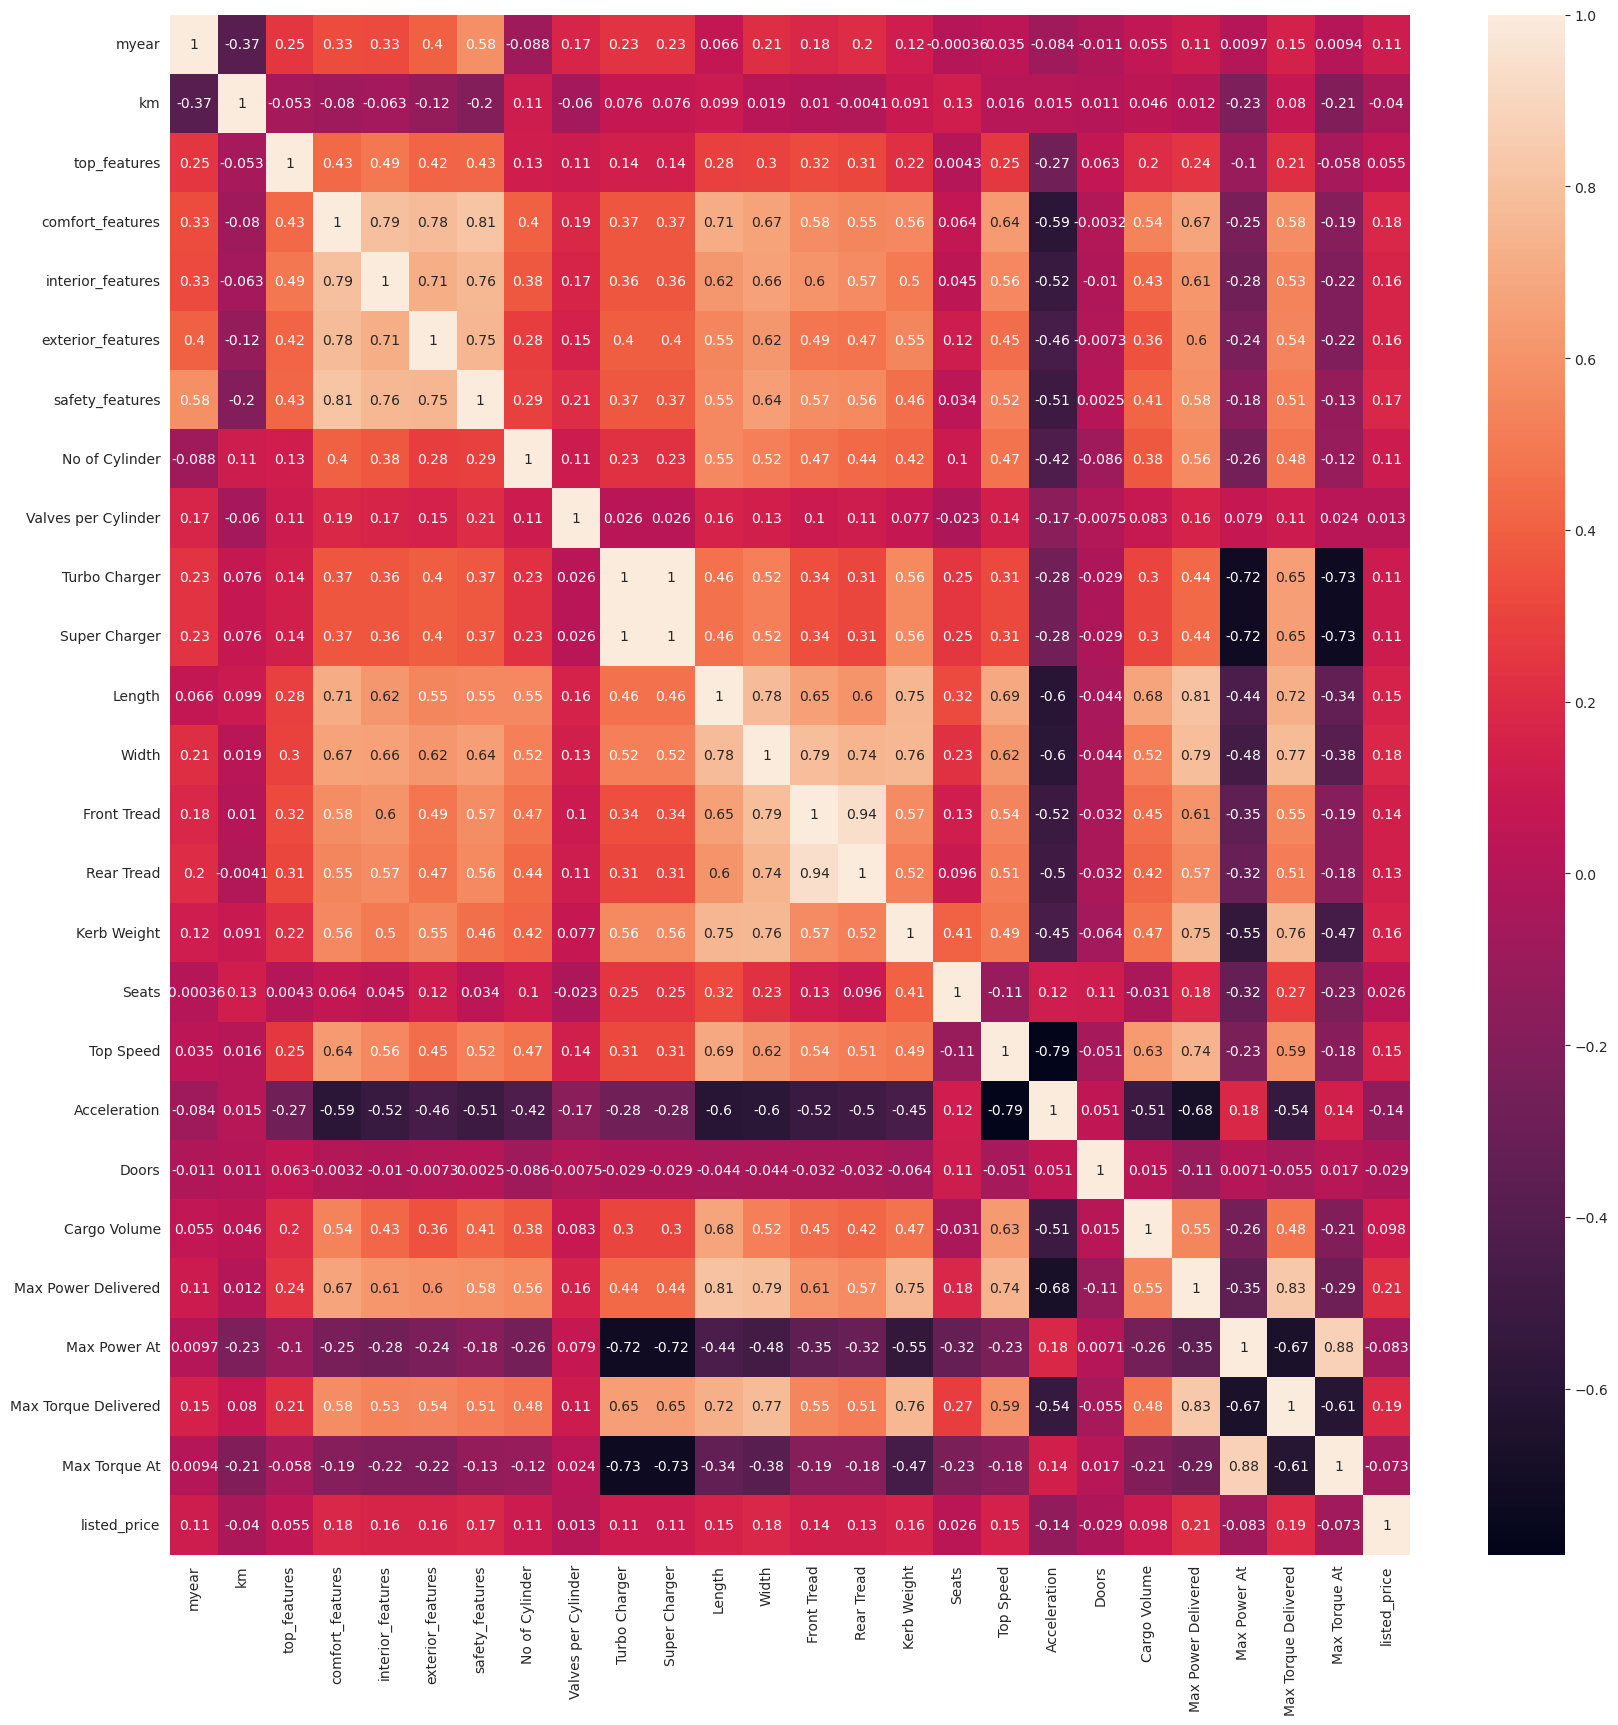

In [61]:
plt.figure(figsize = (20, 20))
sns.heatmap(data = corr_mat, annot = True)
plt.show()

**REPORT**:
- The correlation map is definitely giving a lot of crucial information
- *Front Tread* and *Rear Tread* have very high corr -> (0.94)
- *Max Torque At* and *Max Power At* have very high corr -> (0.88)
- *Acceleration* and *Top Speed* are highly negatively correlated -> (-0.79)
- *Wheel Base*, *Length* and *Width*  are also highly correlated
- *Valves per Cylinder* is also a column with very high correlation with multiple columns
- All the *car_features* columns are highly correlated too


**Feature Engineering Ideas**:
- avg_measure = $\frac{length + width}{3}$
- Features = $top + comfort + interior + exterior + safety$
- Total Valves = No. of Cylinders $\times$ Valves per Cylinder
- Tread = $\frac{Front Tread + Rear Tread}{2}$

In [62]:
cat_cols = [col for col in train.columns
           if train[col].dtype == 'O']
cat_un = [train[col].nunique() for col in cat_cols]
cat_info = pd.DataFrame({'column' : cat_cols, 'unique values' : cat_un})
cat_info

,column,unique values
0,transmission,2
1,fuel,5
2,Valve Configuration,5
3,Drive Type,4
4,owner_type,6
5,Fuel Supply System,10
6,body,11
7,Gear Box,11
8,Steering Type,2
9,Front Brake Type,5


In [63]:
num_cols = [col for col in train.columns
           if col not in cat_cols]
num_un = [train[col].nunique() for col in num_cols]
num_info = pd.DataFrame({'column' : num_cols, 'unique values' : num_un})
num_info

,column,unique values
0,myear,33
1,km,21733
2,top_features,10
3,comfort_features,39
4,interior_features,20
5,exterior_features,28
6,safety_features,50
7,No of Cylinder,11
8,Valves per Cylinder,7
9,Turbo Charger,2


In [64]:
heh = [col for col in num_cols if train[col].nunique() > 50]

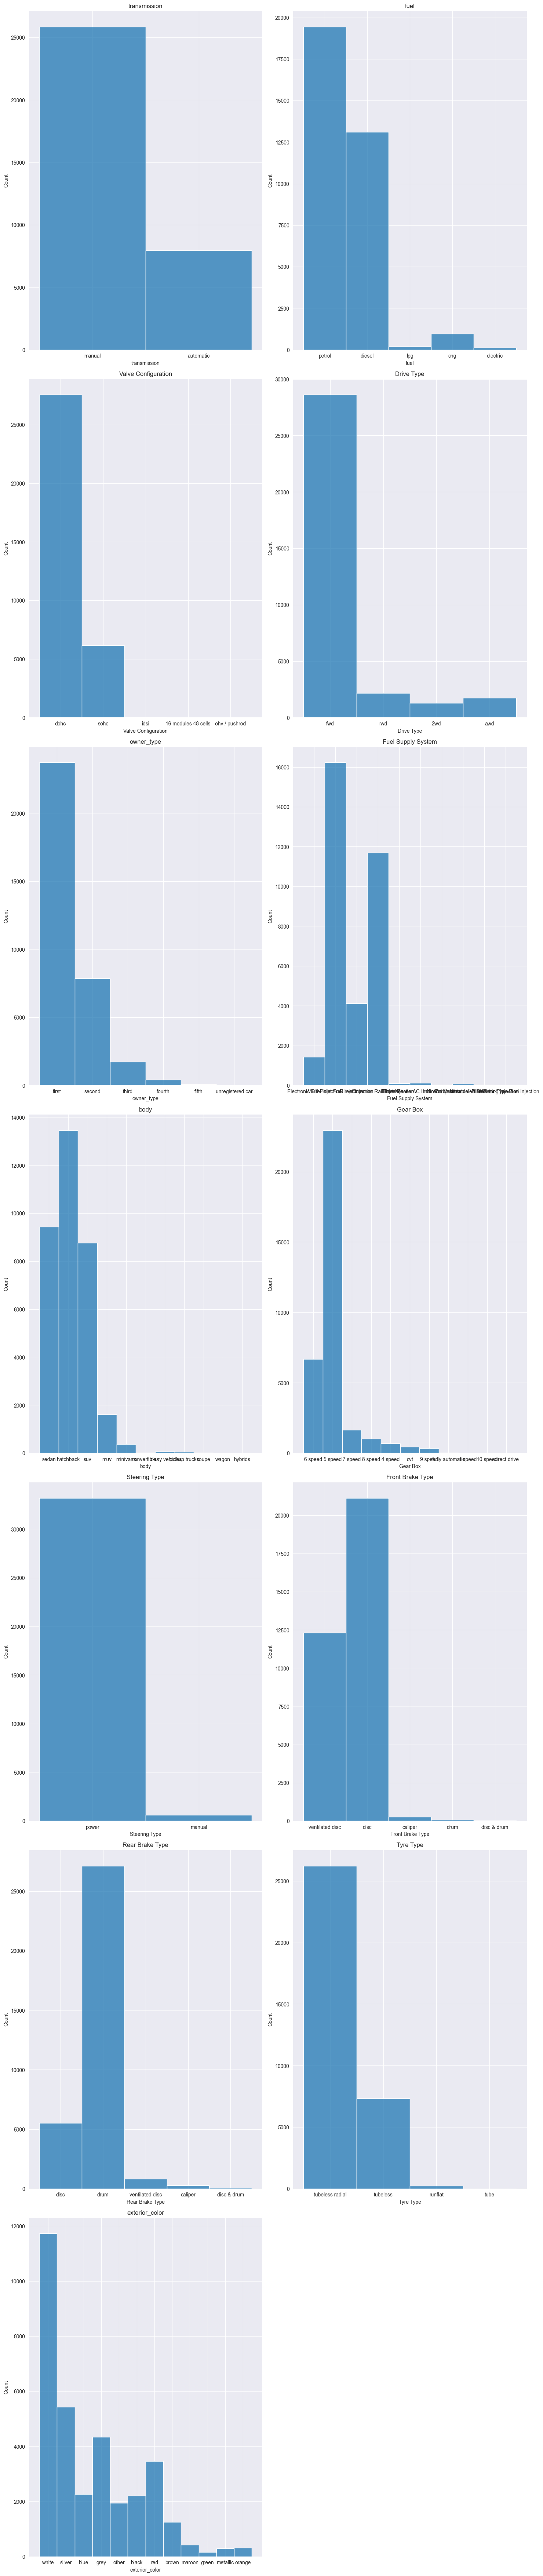

In [135]:
#Plotting categorical features distribution
i = 1
plt.figure(figsize = (15, 100))
for col in cat_cols:
    plt.subplot(10, 2, i)
    sns.histplot(data = train[col])
    plt.title(col)
    i+= 1
plt.tight_layout()

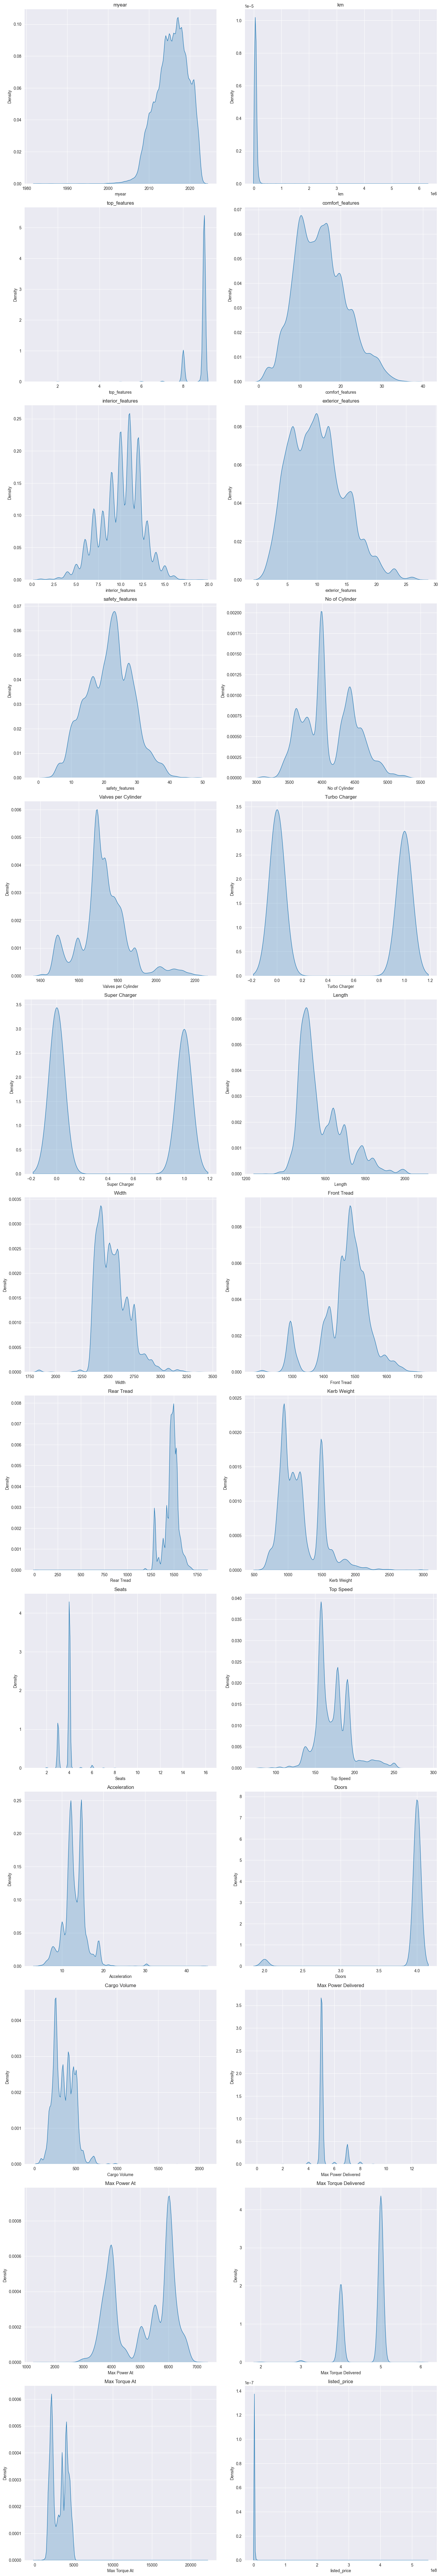

In [136]:
#plotting distribution of numerical features
j = 1
plt.figure(figsize = (15, 100))
for col in num_cols:
    plt.subplot(15, 2, j)
    sns.kdeplot(data = train[col], fill = True)
    plt.title(col)
    j += 1
plt.tight_layout()    

## Outliers 

In [65]:
#number summaries for data
desc = train.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
myear,33776.0,2015.578636,3.774640e+00,1983.0,2013.000000,2016.000000,2018.000000,2.023000e+03
km,33776.0,62224.967314,5.498804e+04,101.0,31755.500000,56520.500000,83028.250000,6.300000e+06
top_features,33776.0,8.817383,4.835136e-01,1.0,9.000000,9.000000,9.000000,9.000000e+00
comfort_features,33776.0,15.090182,6.072644e+00,1.0,10.000000,15.000000,19.000000,3.900000e+01
interior_features,33776.0,10.070956,2.345593e+00,1.0,9.000000,10.000000,12.000000,1.900000e+01
exterior_features,33776.0,10.060648,4.576099e+00,1.0,6.000000,10.000000,13.000000,2.700000e+01
safety_features,33776.0,21.709257,6.926763e+00,1.0,17.000000,22.000000,27.000000,4.900000e+01
No of Cylinder,33776.0,3.816520,5.294341e-01,1.0,4.000000,4.000000,4.000000,1.600000e+01
Valves per Cylinder,33776.0,3.892942,4.842483e-01,1.0,4.000000,4.000000,4.000000,4.800000e+01
Length,33776.0,4112.195622,3.965827e+02,3099.0,3795.000000,3995.000000,4440.000000,5.469000e+03


In [66]:
train_outliers = {}
test_outliers = {}

In [67]:
def outliers(col):
    var_name = f"{col}_outliers"
    train_outliers[var_name] = []
    test_outliers[var_name] = []
    iqr = desc.loc[col, '75%'] - desc.loc[col, '25%']
    h_brac = desc.loc[col, '75%'] + 1.5 * iqr
    l_brac = desc.loc[col, '25%'] - 1.5 * iqr
    trouts = train.loc[(train[col] < l_brac) | (train[col] > h_brac)]
    teouts = test.loc[(test[col] < l_brac) | (test[col] > h_brac)]
    train_outliers[var_name] = list(trouts.index)
    test_outliers[var_name] = list(teouts.index)  

In [68]:
for col in heh:
    outliers(col)

In [69]:
print("For the train dataset:")
for col in heh:
    var = f"{col}_outliers"
    print(f"The no. of outliers in {col}:", len(train.iloc[train_outliers[var]]))

For the train dataset:
The no. of outliers in km: 766
The no. of outliers in Length: 4
The no. of outliers in Width: 3996
The no. of outliers in Front Tread: 3757
The no. of outliers in Rear Tread: 4067
The no. of outliers in Kerb Weight: 130
The no. of outliers in Top Speed: 1202
The no. of outliers in Acceleration: 700
The no. of outliers in Cargo Volume: 70
The no. of outliers in Max Power Delivered: 1764
The no. of outliers in Max Power At: 0
The no. of outliers in Max Torque Delivered: 1714
The no. of outliers in Max Torque At: 1
The no. of outliers in listed_price: 2841


In [70]:
print("For the test dataset:")
for col in heh:
    var = f"{col}_outliers"
    print(f"The no. of outliers in {col}:", len(test.iloc[test_outliers[var]]))

For the test dataset:
The no. of outliers in km: 98
The no. of outliers in Length: 0
The no. of outliers in Width: 449
The no. of outliers in Front Tread: 427
The no. of outliers in Rear Tread: 474
The no. of outliers in Kerb Weight: 16
The no. of outliers in Top Speed: 149
The no. of outliers in Acceleration: 92
The no. of outliers in Cargo Volume: 13
The no. of outliers in Max Power Delivered: 215
The no. of outliers in Max Power At: 0
The no. of outliers in Max Torque Delivered: 211
The no. of outliers in Max Torque At: 1
The no. of outliers in listed_price: 345


-**REPORT:**
- The outliers are not really outliers in most cases, they exist in the real world and are not a consequence of illegitimate data entries
-There were outliers on the basis of the car makers which have been removed at the beginning
(Car makers having less than 6 listings in the dataset)

# Pipelines

In [71]:
from dirty_cat import SuperVectorizer, TableVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import RobustScaler

In [72]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

In [75]:
#Scaler
rs = RobustScaler()

In [76]:
#Encoder objects
tv = TableVectorizer()
sv = SuperVectorizer()

In [77]:
#Table Vectorizer dataset
tv_X_train = tv.fit_transform(X_train, y_train)
tv_X_test = tv.transform(X_test)

In [78]:
#SuperVectorizer dataset
sv_X_train = sv.fit_transform(X_train, y_train)
sv_X_test = sv.transform(X_test)

## 1.Laborious pipeline

In [79]:
#Creating the new train and test
lX_train = train.drop('listed_price', axis = 1)
ly_train = train['listed_price']
testX = test.drop('listed_price', axis = 1)
testy = test['listed_price']
lX_test, lX_valid, ly_test, ly_valid = train_test_split(testX, testy, train_size = 0.5)

In [80]:
catcols = [col for col in lX_train if lX_train[col].dtype == 'O']
catvals = [lX_train[col].nunique() for col in catcols]
katie = pd.DataFrame({'catcols': catcols, 'Uniques' : catvals})
katie

,catcols,Uniques
0,transmission,2
1,fuel,5
2,Valve Configuration,5
3,Drive Type,4
4,owner_type,6
5,Fuel Supply System,10
6,body,11
7,Gear Box,11
8,Steering Type,2
9,Front Brake Type,5


### 1.1. Feature Engineering

In [83]:
#Adding avg_measure to the dataset
lX_train['avg_measure'] = (lX_train['Length'] + lX_train['Width']) / 2
lX_test['avg_measure'] = (lX_test['Length'] + lX_test['Width']) / 2
lX_valid['avg_measure'] = (lX_valid['Length'] + lX_valid['Width']) / 2

In [84]:
#Defining features
features = ['top_features',
 'comfort_features',
 'interior_features',
 'exterior_features',
 'safety_features']
lX_test['Features'] = np.sum(lX_test[features], axis = 1)
lX_valid['Features'] = np.sum(lX_valid[features], axis = 1)
lX_train['Features'] = np.sum(lX_train[features], axis = 1)

In [92]:
cyl = ['No of Cylinder', 'Valves per Cylinder']
lX_train['No of Cylinder'] * lX_train['Valves per Cylinder']

0        16.0
1        16.0
2        16.0
3        32.0
4        16.0
         ... 
33771    12.0
33772    16.0
33773    12.0
33774    12.0
33775    16.0
Length: 33776, dtype: float64

In [93]:
#Valves featur
lX_train['Valves'] = lX_train['No of Cylinder'] * lX_train['Valves per Cylinder']
lX_test['Valves'] = lX_test['No of Cylinder'] * lX_test['Valves per Cylinder']
lX_valid['Valves'] = lX_valid['No of Cylinder'] * lX_valid['Valves per Cylinder']

In [95]:
lX_valid['Valves']

3266    12.0
297     16.0
3339    12.0
2802    12.0
2946    16.0
        ... 
247     16.0
2718    16.0
774     12.0
754     16.0
1123    16.0
Name: Valves, Length: 1888, dtype: float64

In [96]:
lX_train['Tread'] = (lX_train['Front Tread'] + lX_train['Rear Tread'])/ 2
lX_valid['Tread'] = (lX_valid['Front Tread'] + lX_valid['Rear Tread'])/ 2
lX_test['Tread'] = (lX_test['Front Tread'] + lX_test['Rear Tread'])/ 2

In [98]:
lX_train.columns

Index(['myear', 'transmission', 'fuel', 'km', 'top_features',
       'comfort_features', 'interior_features', 'exterior_features',
       'safety_features', 'No of Cylinder', 'Valves per Cylinder',
       'Valve Configuration', 'Turbo Charger', 'Super Charger', 'Length',
       'Width', 'Front Tread', 'Rear Tread', 'Kerb Weight', 'Drive Type',
       'Seats', 'Top Speed', 'Acceleration', 'Doors', 'Cargo Volume',
       'owner_type', 'Fuel Supply System', 'Max Power Delivered',
       'Max Power At', 'Max Torque Delivered', 'Max Torque At', 'body',
       'Gear Box', 'Steering Type', 'Front Brake Type', 'Rear Brake Type',
       'Tyre Type', 'exterior_color', 'avg_measure', 'Features', 'Valves',
       'Tread'],
      dtype='object')

In [101]:
to_drop = ['top_features', 'No of Cylinder', 'Valves per Cylinder',
       'comfort_features', 'interior_features', 'exterior_features',
       'safety_features','Length', 'Width', 'Front Tread', 'Rear Tread']

In [102]:
#Dropping the columns
lX_train = lX_train.drop(to_drop, axis = 1)
lX_valid = lX_valid.drop(to_drop, axis = 1)
lX_test = lX_test.drop(to_drop, axis = 1)

In [111]:
lcat = [col for col in lX_train if lX_train[col].dtype == 'O']
lc = [lX_train[col].nunique() for col in lcat]
linfo = pd.DataFrame({'name' : lcat, 'unique' : lc})
linfo

,name,unique
0,transmission,2
1,fuel,5
2,Valve Configuration,5
3,Drive Type,4
4,owner_type,6
5,Fuel Supply System,10
6,body,11
7,Gear Box,11
8,Steering Type,2
9,Front Brake Type,5


In [116]:
from sklearn.preprocessing import OneHotEncoder


### 2.Vectorizer pipeline

In [ ]:
#Creating the necessary objects
rf = RandomForestRegressor()
xg = XGBRegressor()
lr = LinearRegression()
ls = Lasso()
rg = Ridge()
el = ElasticNet()
lg = LGBMRegressor(boosting_type = 'rf')
cat = CatBoostRegressor(loss_function = 'MAE', eval_metric = 'MAE', verbose = 0)
gb = GradientBoostingRegressor(loss = 'absolute_error')
hgb = HistGradientBoostingRegressor(loss = 'absolute_error')
ab = AdaBoostRegressor()
et = ExtraTreesRegressor()
dt = DecisionTreeRegressor()
reg = [lr, ls, rg, el, dt, et, rf, ab, gb, hgb, xg, lg, cat]
tags = ['lr', 'ls', 'rg', 'el', 'dt', 'et', 'rf', 'ab', 'gb', 'hgb', 'xg', 'lg', 'cat']

In [ ]:
def pipl(model, encoder,  X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(encoder, model)
    
    pipeline.fit(X_train, y_train)
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)
    train_score = mean_absolute_error(y_train, train_preds)
    test_score = mean_absolute_error(y_test, test_preds)
    train_percent = train_score * 100 / y_train.mean()
    test_percent = test_score * 100 / y_test.mean()
    #print("For Train-Test")
    #print("MAE% on train: ", train_percent)
    #print("MAE% on test: ", test_percent)
    return train_percent, test_percent

In [ ]:
%%time
bois = pipl(cat, tv, X_train, y_train, X_test, y_test)#Model performs better without scaler
print("Train MAE: ", bois[0])
print("Test MAE: ", bois[1])

In [ ]:
scoresheet1 = pd.DataFrame(index = tags, data = {'train_score' : np.nan, 'test_score' : np.nan})

In [ ]:
%%time
i = 0
for regressor in reg:
    vals = pipl(regressor, sv, X_train, y_train, X_test, y_test)
    var_name = tags[i]
    scoresheet1.loc[var_name, 'train_score'] = vals[0]
    scoresheet1.loc[var_name, 'test_score'] = vals[1]
    i+=1

In [ ]:
scoresheet1

In [ ]:
scoresheet2 = pd.DataFrame(index = tags, data = {'train_score' : np.nan, 'test_score' : np.nan})

In [136]:
%%time
i = 0
for regressor in reg:
    vals = pipl(regressor, tv, X_train, y_train, X_test, y_test)
    var_name = tags[i]
    scoresheet2.loc[var_name, 'train_score'] = vals[0]
    scoresheet2.loc[var_name, 'test_score'] = vals[1]
    i+=1

C:\Users\rajni\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+17, tolerance: 3.449e+13
  model = cd_fast.enet_coordinate_descent(


Learning rate set to 0.071401
0:	learn: 3180150.5240153	total: 14.7ms	remaining: 14.7s
1:	learn: 3165050.3808187	total: 27.2ms	remaining: 13.6s
2:	learn: 3152325.1548726	total: 39.3ms	remaining: 13.1s
3:	learn: 3142567.7441732	total: 52.1ms	remaining: 13s
4:	learn: 3132321.4742144	total: 65.7ms	remaining: 13.1s
5:	learn: 3085427.5018755	total: 79.1ms	remaining: 13.1s
6:	learn: 3083584.3886225	total: 90.7ms	remaining: 12.9s
7:	learn: 3075196.5825219	total: 103ms	remaining: 12.7s
8:	learn: 3066814.6156667	total: 115ms	remaining: 12.6s
9:	learn: 3065446.5995029	total: 126ms	remaining: 12.5s
10:	learn: 3058913.7370376	total: 138ms	remaining: 12.4s
11:	learn: 3057500.6790531	total: 144ms	remaining: 11.9s
12:	learn: 3053593.1180276	total: 156ms	remaining: 11.9s
13:	learn: 3052413.1241663	total: 167ms	remaining: 11.7s
14:	learn: 3042889.6641348	total: 180ms	remaining: 11.8s
15:	learn: 3041774.4871807	total: 192ms	remaining: 11.8s
16:	learn: 3034682.5032848	total: 204ms	remaining: 11.8s
17:	le

151:	learn: 2693791.7217804	total: 1.9s	remaining: 10.6s
152:	learn: 2693664.5231173	total: 1.92s	remaining: 10.6s
153:	learn: 2693555.5890498	total: 1.93s	remaining: 10.6s
154:	learn: 2693524.1158771	total: 1.94s	remaining: 10.6s
155:	learn: 2693407.8392096	total: 1.95s	remaining: 10.6s
156:	learn: 2692093.5692092	total: 1.97s	remaining: 10.6s
157:	learn: 2691966.0962301	total: 1.98s	remaining: 10.5s
158:	learn: 2691901.6192562	total: 1.99s	remaining: 10.5s
159:	learn: 2691757.6807215	total: 2s	remaining: 10.5s
160:	learn: 2691229.1901001	total: 2.02s	remaining: 10.5s
161:	learn: 2691186.8648885	total: 2.03s	remaining: 10.5s
162:	learn: 2691078.1479322	total: 2.04s	remaining: 10.5s
163:	learn: 2689391.4212980	total: 2.05s	remaining: 10.5s
164:	learn: 2689299.2937491	total: 2.07s	remaining: 10.5s
165:	learn: 2689166.6940619	total: 2.08s	remaining: 10.4s
166:	learn: 2689145.2364296	total: 2.09s	remaining: 10.4s
167:	learn: 2642063.4043739	total: 2.1s	remaining: 10.4s
168:	learn: 2641999

306:	learn: 1726458.7187320	total: 3.84s	remaining: 8.66s
307:	learn: 1697002.7153461	total: 3.85s	remaining: 8.65s
308:	learn: 1667918.4834697	total: 3.87s	remaining: 8.64s
309:	learn: 1639578.0384740	total: 3.88s	remaining: 8.64s
310:	learn: 1611703.5392230	total: 3.9s	remaining: 8.63s
311:	learn: 1584610.1891275	total: 3.91s	remaining: 8.63s
312:	learn: 1558040.7184963	total: 3.93s	remaining: 8.62s
313:	learn: 1531985.5043694	total: 3.94s	remaining: 8.61s
314:	learn: 1506435.1698922	total: 3.96s	remaining: 8.61s
315:	learn: 1481380.5717688	total: 3.97s	remaining: 8.6s
316:	learn: 1456812.7888455	total: 3.99s	remaining: 8.59s
317:	learn: 1432723.1117003	total: 4s	remaining: 8.58s
318:	learn: 1409103.0331210	total: 4.02s	remaining: 8.57s
319:	learn: 1383316.4855961	total: 4.03s	remaining: 8.56s
320:	learn: 1360560.7856975	total: 4.04s	remaining: 8.55s
321:	learn: 1338249.9685221	total: 4.06s	remaining: 8.54s
322:	learn: 1313916.1060899	total: 4.07s	remaining: 8.53s
323:	learn: 1292074

465:	learn: 589749.1869467	total: 5.97s	remaining: 6.84s
466:	learn: 582309.7346075	total: 5.99s	remaining: 6.83s
467:	learn: 582267.4596098	total: 6s	remaining: 6.82s
468:	learn: 582245.8399613	total: 6.01s	remaining: 6.8s
469:	learn: 581738.8800466	total: 6.02s	remaining: 6.79s
470:	learn: 581667.7890064	total: 6.04s	remaining: 6.78s
471:	learn: 581612.4834140	total: 6.05s	remaining: 6.77s
472:	learn: 581018.0489739	total: 6.06s	remaining: 6.76s
473:	learn: 580954.2699424	total: 6.08s	remaining: 6.75s
474:	learn: 580927.6114216	total: 6.09s	remaining: 6.73s
475:	learn: 580875.6376952	total: 6.1s	remaining: 6.72s
476:	learn: 580843.4824720	total: 6.11s	remaining: 6.7s
477:	learn: 580774.9081361	total: 6.13s	remaining: 6.69s
478:	learn: 580701.3054746	total: 6.14s	remaining: 6.68s
479:	learn: 580686.0673957	total: 6.15s	remaining: 6.67s
480:	learn: 573146.8027607	total: 6.17s	remaining: 6.65s
481:	learn: 573052.0528704	total: 6.18s	remaining: 6.64s
482:	learn: 572603.6489674	total: 6.1

624:	learn: 449198.1764544	total: 8.08s	remaining: 4.85s
625:	learn: 444122.9389321	total: 8.1s	remaining: 4.84s
626:	learn: 444051.5009962	total: 8.11s	remaining: 4.83s
627:	learn: 439068.7184509	total: 8.13s	remaining: 4.81s
628:	learn: 438028.1470151	total: 8.14s	remaining: 4.8s
629:	learn: 437882.9448687	total: 8.16s	remaining: 4.79s
630:	learn: 437836.0839457	total: 8.17s	remaining: 4.78s
631:	learn: 437696.7795268	total: 8.18s	remaining: 4.76s
632:	learn: 435261.0257278	total: 8.2s	remaining: 4.75s
633:	learn: 435257.7570346	total: 8.21s	remaining: 4.74s
634:	learn: 430471.9957810	total: 8.22s	remaining: 4.73s
635:	learn: 430467.1185049	total: 8.23s	remaining: 4.71s
636:	learn: 430362.5367368	total: 8.25s	remaining: 4.7s
637:	learn: 430311.8587908	total: 8.26s	remaining: 4.69s
638:	learn: 430241.0834271	total: 8.27s	remaining: 4.67s
639:	learn: 430229.6552455	total: 8.29s	remaining: 4.66s
640:	learn: 425277.4491212	total: 8.3s	remaining: 4.65s
641:	learn: 420695.3258340	total: 8.

783:	learn: 333938.7727071	total: 10.2s	remaining: 2.81s
784:	learn: 333890.6105769	total: 10.2s	remaining: 2.8s
785:	learn: 330876.4492780	total: 10.2s	remaining: 2.79s
786:	learn: 330803.0103172	total: 10.3s	remaining: 2.78s
787:	learn: 330749.9236440	total: 10.3s	remaining: 2.76s
788:	learn: 330635.6114180	total: 10.3s	remaining: 2.75s
789:	learn: 330624.2532539	total: 10.3s	remaining: 2.74s
790:	learn: 330529.3849670	total: 10.3s	remaining: 2.72s
791:	learn: 330461.8542995	total: 10.3s	remaining: 2.71s
792:	learn: 330363.9809642	total: 10.3s	remaining: 2.7s
793:	learn: 330330.8345489	total: 10.3s	remaining: 2.68s
794:	learn: 330032.2968404	total: 10.4s	remaining: 2.67s
795:	learn: 329989.3053174	total: 10.4s	remaining: 2.66s
796:	learn: 329985.7080551	total: 10.4s	remaining: 2.65s
797:	learn: 329877.0207752	total: 10.4s	remaining: 2.63s
798:	learn: 329847.3279571	total: 10.4s	remaining: 2.62s
799:	learn: 329814.7068181	total: 10.4s	remaining: 2.61s
800:	learn: 329752.7026069	total:

943:	learn: 302901.5040841	total: 12.3s	remaining: 731ms
944:	learn: 302801.7365075	total: 12.3s	remaining: 718ms
945:	learn: 302767.6363181	total: 12.3s	remaining: 705ms
946:	learn: 302711.9110664	total: 12.4s	remaining: 692ms
947:	learn: 302596.8837956	total: 12.4s	remaining: 679ms
948:	learn: 302571.9521765	total: 12.4s	remaining: 666ms
949:	learn: 302541.0126579	total: 12.4s	remaining: 653ms
950:	learn: 302513.9292361	total: 12.4s	remaining: 640ms
951:	learn: 302464.7633496	total: 12.4s	remaining: 627ms
952:	learn: 302460.0064602	total: 12.4s	remaining: 614ms
953:	learn: 302445.4418107	total: 12.5s	remaining: 600ms
954:	learn: 302389.7103047	total: 12.5s	remaining: 587ms
955:	learn: 302352.3972621	total: 12.5s	remaining: 574ms
956:	learn: 302351.2384963	total: 12.5s	remaining: 561ms
957:	learn: 302334.0600866	total: 12.5s	remaining: 548ms
958:	learn: 302310.2429926	total: 12.5s	remaining: 535ms
959:	learn: 302200.3554619	total: 12.5s	remaining: 522ms
960:	learn: 302170.2720993	tota

In [137]:
scoresheet2

,train_score,test_score
lr,35.474589,35.506236
ls,35.469078,35.437952
rg,35.679770,35.545026
el,39.071232,39.840766
dt,0.000000,16.657764
et,0.005530,12.639187
rf,6.666635,13.459264
ab,37.362337,69.169891
gb,21.678850,21.517479
hgb,20.183958,19.143066


**REPORT:**
- Combination of SuperVectorizer and RandomForest performs the best (12.6)
- Addition of Robust Scaler lowers it to (13.7)
- Using TableVectorizer instead also lowers it to (13.4) without Robust Scaler

**REPORT:**
- After applying some hyperparameters these are the better performing models:
    - CatBoostRegressor
    - HistGradientBoostingRegressor
    - ExtraTreesRegressor
    - RandomForestRegressor
    

### Train-test-valid split for cross validation and Hyperparmater optimization

In [89]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size = 0.5, random_state = 42)

In [90]:
sv_X_valid = sv.transform(X_valid)
tv_X_valid = tv.transform(X_valid)

In [91]:
def maepercent(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae * 100 / y_true.mean()

In [94]:
cat_params = {'iterations': 264,
 'learning_rate': 0.15322245695737738,
 'depth': 9,
 'l2_leaf_reg': 5.562675266419676,
 'early_stopping_rounds': 14}

hgb_params = {'max_iter': 333,
 'learning_rate': 0.15393558857357315,
 'max_depth': 9,
 'l2_regularization': 0.8655633274690765,
 'min_samples_leaf': 17}

{'iterations': 264,
 'learning_rate': 0.15322245695737738,
 'depth': 9,
 'l2_leaf_reg': 5.562675266419676,
 'early_stopping_rounds': 14}

In [98]:
best_hyperparams#hgb

{'max_iter': 333,
 'learning_rate': 0.15393558857357315,
 'max_depth': 9,
 'l2_leaf_reg': 0.8655633274690765,
 'min_samples_leaf': 17}

In [ ]:
def objective(trial):
    model= ExtraTreesRegressor(
        n_estimators = trial.suggest_int('n_estimators', 100, 1500),
        max_depth = trial.suggest_int('max_depth', 1, 15), # depth above 10 usually introduces overfitting
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20),
        min_samples_split = trial.suggest_int('min_samples_split', 1, 20),
        max_features = trial.suggest_categorical('max_features', ['auto', 'log2', 'sqrt']),
        criterion = 'absolute_error'
    )

    
    model.fit(sv_X_train, y_train)

    return maepercent(y_valid, model.predict(sv_X_valid))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params

[I 2023-08-19 16:37:58,286] A new study created in memory with name: no-name-5f2fe01b-cef4-4c84-9375-9c7d6b9cbf69


In [ ]:
best_hyperparams

### Dirty implementation

In [75]:
ntrain = train[num_cols]
ntest = test[num_cols]

In [76]:
nX_train = ntrain.drop('listed_price', axis = 1)
ny_train = ntrain['listed_price']
nX_test = ntest.drop(['listed_price'], axis = 1)
ny_test = ntest['listed_price']

In [78]:
lr = RandomForestRegressor()
lr.fit(nX_train, ny_train)
preds = lr.predict(nX_test)

In [79]:
mae = mean_absolute_error(ny_test, preds)
mae_percent = mae * 100/ ny_test.mean()

In [80]:
print('MAE: ', mae)
print('MAE percent: ', mae_percent)

MAE:  102584.15517648886
MAE percent:  12.971815950151319
